# Descrição do Dataset cStick

Este dataset contém aproximadamente 2040 amostras com os seguintes parâmetros, relacionados à decisão de quedas:

- **Distance**: Distância do usuário até o objeto/pessoa/coisa mais próxima.
- **Pressure**: Pressão da mão aplicada ao bastão (0 = baixa, 1 = média, 2 = alta).
- **HRV**: Variabilidade da frequência cardíaca do usuário.
- **Sugar level**: Nível de glicose do usuário.
- **SpO2**: Níveis de saturação de oxigênio no sangue do usuário.
- **Accelerometer**: Leitura do acelerômetro do usuário (valor binário: < ±3g → 0, > limiar → 1).
- **Decision**: Decisão de queda (0 = nenhuma queda detectada, 1 = escorregão/tropeço/predição de queda, 2 = queda confirmada).

O arquivo `cStick.csv` contém as colunas acima e a relação entre os sinais medidos e a decisão de queda. Esse conjunto pode ser usado para análise exploratória, balanceamento de classes e modelagem preditiva de quedas.

## Plano de Análise e Preparação

Objetivo: preparar o dataset da bengala inteligente para o treinamento de uma rede neural profunda (classificação pela coluna `Decision`).

Passos:
- Auditoria do dado: dimensões, tipos, valores faltantes, estatísticas.
- Balanceamento de classes: distribuição da `Decision`.
- Tratamento e codificação: garantir tipos corretos, encoding para categóricos, preenchimento de faltantes.
- Normalização/Padronização: preparar escalas para redes neurais.
- Correlações e insights: verificar relação entre variáveis.
- Split estratificado: treino/validação/teste para modelagem.

Ao final, teremos `X` e `y` prontos para treinamento.

In [51]:
import pandas as pd

df = pd.read_csv('cStick.csv')
df.head()

,Distance,Pressure,HRV,Sugar level,SpO2,Accelerometer,Decision
0,25.540,1.0,101.396,61.080,87.770,1.0,1
1,2.595,2.0,110.190,20.207,65.190,1.0,2
2,68.067,0.0,87.412,79.345,99.345,0.0,0
3,13.090,1.0,92.266,36.180,81.545,1.0,1
4,69.430,0.0,89.480,80.000,99.990,0.0,0


In [52]:
# Auditoria do dado
print('Dimensões:', df.shape)
print('\nTipos de dados:')
print(df.dtypes)

print('\nPrimeiras linhas:')
display(df.head())

print('\nValores faltantes por coluna:')
print(df.isna().sum())

# Estatísticas descritivas
print('\nEstatísticas numéricas:')
display(df.describe(include=['float', 'int']))

print('\nEstatísticas categóricas:')
obj_cols = df.select_dtypes(include=['object']).columns
if len(obj_cols) > 0:
	display(df.describe(include=['object']))
else:
	print('Nenhuma coluna categórica (object) encontrada.')

Dimensões: (2039, 7)

Tipos de dados:
Distance         float64
Pressure         float64
HRV              float64
Sugar level      float64
SpO2             float64
Accelerometer    float64
Decision           int64
dtype: object

Primeiras linhas:


,Distance,Pressure,HRV,Sugar level,SpO2,Accelerometer,Decision
0,25.540,1.0,101.396,61.080,87.770,1.0,1
1,2.595,2.0,110.190,20.207,65.190,1.0,2
2,68.067,0.0,87.412,79.345,99.345,0.0,0
3,13.090,1.0,92.266,36.180,81.545,1.0,1
4,69.430,0.0,89.480,80.000,99.990,0.0,0



Valores faltantes por coluna:
Distance         0
Pressure         0
HRV              0
Sugar level      0
SpO2             0
Accelerometer    0
Decision         0
dtype: int64

Estatísticas numéricas:


,Distance,Pressure,HRV,Sugar level,SpO2,Accelerometer,Decision
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000
mean,28.694527,0.988720,95.657002,72.909243,83.563649,0.661599,0.988720
std,23.773644,0.815918,17.576499,46.940110,11.111592,0.473282,0.815918
min,0.000000,0.000000,60.000000,10.000000,60.000000,0.000000,0.000000
25%,7.642500,0.000000,82.418000,40.230000,75.285000,0.000000,0.000000
50%,20.560000,1.000000,97.238000,69.960000,85.280000,1.000000,1.000000
75%,55.205500,2.000000,109.695000,77.612500,92.692500,1.000000,2.000000
max,69.981000,2.000000,124.980000,179.293000,99.990000,1.000000,2.000000



Estatísticas categóricas:
Nenhuma coluna categórica (object) encontrada.


In [53]:
# Preparação e pré-processamento

# Garantir tipos adequados
# Pressure e Accelerometer devem ser categóricos discretos (0/1/2 e 0/1)
for cat_col in ['Pressure', 'Accelerometer', 'Decision']:
    if cat_col in df.columns:
        df[cat_col] = pd.to_numeric(df[cat_col], errors='coerce')

# Tratar valores faltantes: estratégia simples (mediana para numéricos, moda para categóricos)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

from collections import Counter

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    moda = df[c].mode(dropna=True)
    if len(moda) > 0:
        df[c] = df[c].fillna(moda.iloc[0])
    else:
        df[c] = df[c].fillna(0)

In [54]:
# Criar dataset padronizado com Z-Score para atributos numéricos
import numpy as np
import pandas as pd

z_df = df.copy()
num_cols_z = z_df.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols_z:
    col_std = z_df[col].std(ddof=0)
    if col_std == 0 or np.isnan(col_std):
        z_df[col] = 0.0
    else:
        z_df[col] = (z_df[col] - z_df[col].mean()) / col_std

print('Z-Score aplicado. Prévia do dataset padronizado:')
display(z_df.head())

Z-Score aplicado. Prévia do dataset padronizado:


,Distance,Pressure,HRV,Sugar level,SpO2,Accelerometer,Decision
0,-0.132723,0.013828,0.326595,-0.252069,0.378648,0.715185,0.013828
1,-1.098104,1.239743,0.827045,-1.123030,-1.653962,0.715185,1.239743
2,1.656546,-1.212086,-0.469207,0.137139,1.420609,-1.398239,-1.212086
3,-0.656540,0.013828,-0.192976,-0.782662,-0.181715,0.715185,0.013828
4,1.713892,-1.212086,-0.351522,0.151097,1.478670,-1.398239,-1.212086


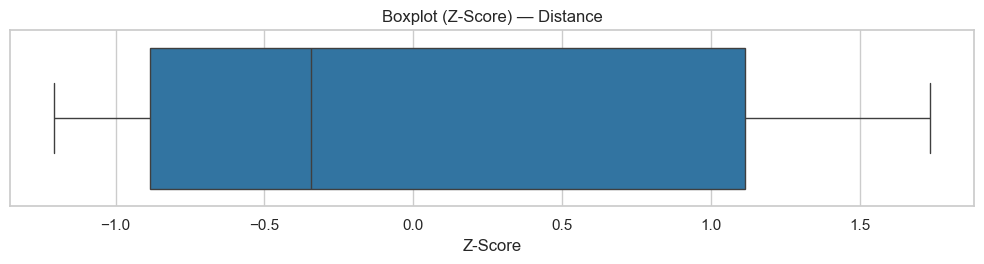

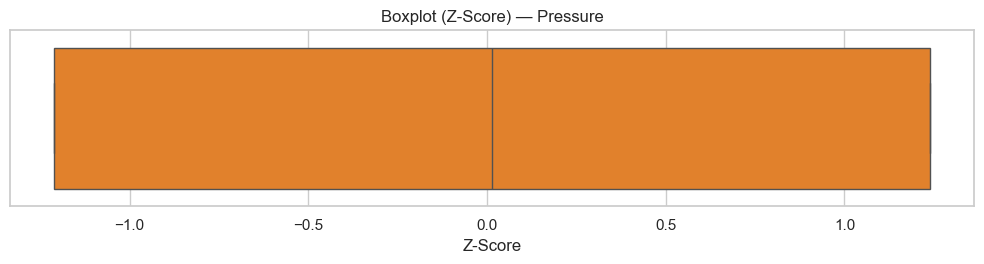

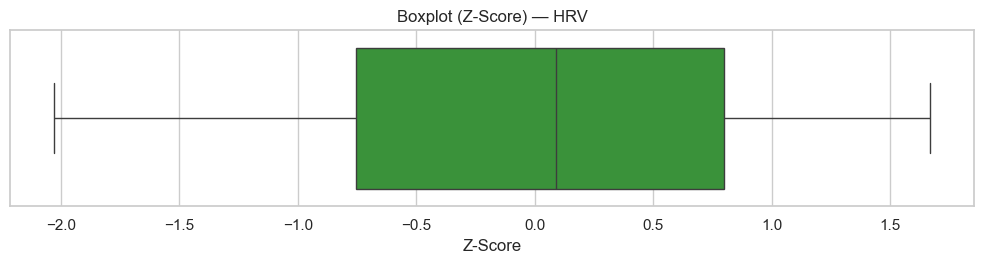

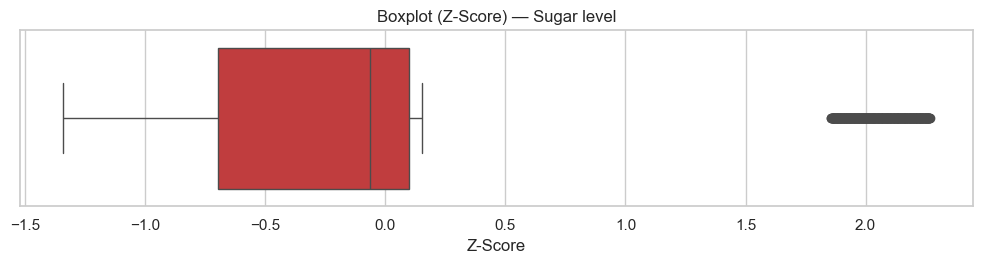

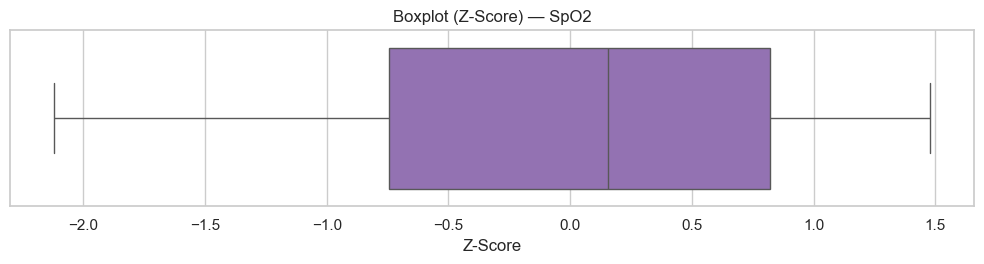

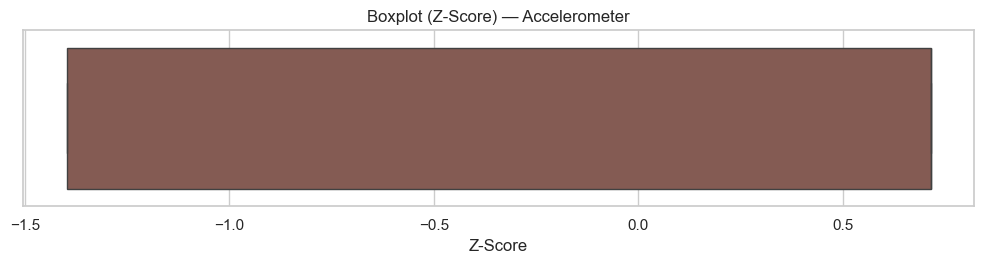

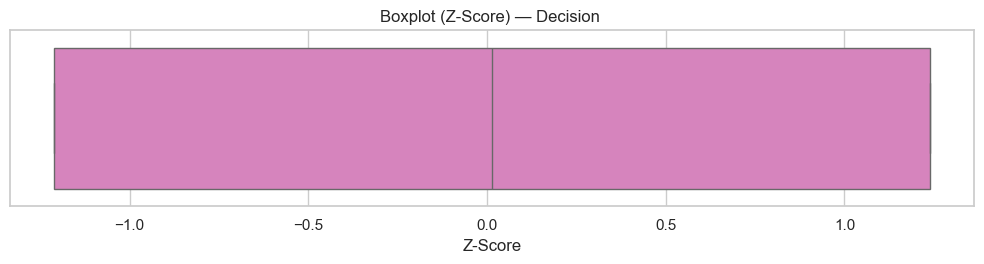

In [55]:
# Boxplots individuais usando o dataset padronizado (z_df)
import seaborn as sns
import matplotlib.pyplot as plt

z_num_cols = z_df.select_dtypes(include=[np.number]).columns.tolist()
z_num = z_df[z_num_cols]

palette = sns.color_palette('tab10', n_colors=len(z_num_cols))
for i, col in enumerate(z_num_cols):
    plt.figure(figsize=(10, 2.8))
    sns.boxplot(x=z_num[col], color=palette[i % len(palette)], orient='h')
    plt.title(f'Boxplot (Z-Score) — {col}')
    plt.xlabel('Z-Score')
    plt.tight_layout()
    plt.show()

,Distance,Pressure,HRV,Sugar level,SpO2,Accelerometer,Decision
Distance,1.000000,-0.946120,-0.816665,0.018344,0.911929,-0.941711,-0.946120
Pressure,-0.946120,1.000000,0.925209,0.156680,-0.923111,0.866866,1.000000
HRV,-0.816665,0.925209,1.000000,0.309212,-0.724080,0.834400,0.925209
Sugar level,0.018344,0.156680,0.309212,1.000000,0.091933,-0.034329,0.156680
SpO2,0.911929,-0.923111,-0.724080,0.091933,1.000000,-0.746666,-0.923111
Accelerometer,-0.941711,0.866866,0.834400,-0.034329,-0.746666,1.000000,0.866866
Decision,-0.946120,1.000000,0.925209,0.156680,-0.923111,0.866866,1.000000


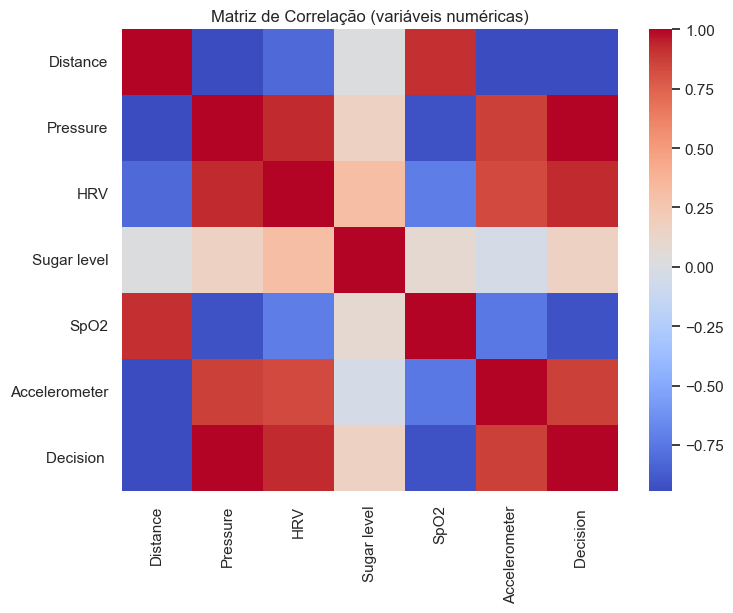

In [56]:
# Correlação entre variáveis numéricas
import numpy as np

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

if len(num_cols) > 1:
    corr = df[num_cols].corr()
    display(corr)
    try:
        import seaborn as sns
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
        plt.title('Matriz de Correlação (variáveis numéricas)')
        plt.show()
    except Exception as e:
        print('Heatmap não disponível:', e)
else:
    print('Colunas numéricas insuficientes para correlação.')

Com base nos dados analisados vemos que os sensores mais com maior correlação para predição de quedas são os de pressão na bengala, a frequencia cardíaca e o acelerometro.